In [1]:
# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler

# Computer Vision / Data imports
from torchvision import transforms
from torchvision.datasets import ImageFolder

# Analysis & Metrics imports
from sklearn.metrics import confusion_matrix, classification_report

# Visualization imports
import matplotlib.pyplot as plt
import seaborn as sns

# Utility imports
import numpy as np
import time

In [2]:
train_loc = '/content/drive/MyDrive/Colab Notebooks/Capstone Project/train'
val_loc = '/content/drive/MyDrive/Colab Notebooks/Capstone Project/val'
test_loc = '/content/drive/MyDrive/Colab Notebooks/Capstone Project/test'

In [3]:
def setup_colab():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if torch.cuda.is_available():
        torch.backends.cudnn.benchmark = True
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
    return device

In [4]:
# Define transforms for VGG16
transform_train = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_eval = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
class VGG16(nn.Module):
    def __init__(self, num_classes):
        super(VGG16, self).__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 5
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

        # Initialize weights
        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

In [6]:
def train_vgg16():
    device = setup_colab()
    scaler = GradScaler()

    # Load datasets with optimized settings
    train_dataset = ImageFolder(train_loc, transform=transform_train)
    val_dataset = ImageFolder(val_loc, transform=transform_eval)
    test_dataset = ImageFolder(test_loc, transform=transform_eval)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,
                            num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False,
                          num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,
                           num_workers=2, pin_memory=True)

    model = VGG16(num_classes=len(train_dataset.classes)).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

    num_epochs = 50
    best_val_acc = 0.0
    history = {'train_loss': [], 'val_loss': [], 'val_acc': [], 'epoch_times': []}

    print("Starting training...")
    for epoch in range(num_epochs):
        epoch_start = time.time()
        model.train()
        running_loss = 0.0

        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            with autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()

            if (i + 1) % 10 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], '
                      f'Step [{i+1}/{len(train_loader)}], '
                      f'Loss: {loss.item():.4f}')

            if i % 50 == 0:
                torch.cuda.empty_cache()

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                with autocast():
                    outputs = model(images)
                    loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_train_loss = running_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * correct / total
        epoch_time = time.time() - epoch_start

        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(val_accuracy)
        history['epoch_times'].append(epoch_time)

        print(f'Epoch [{epoch+1}/{num_epochs}]:')
        print(f'Training Loss: {avg_train_loss:.4f}')
        print(f'Validation Loss: {avg_val_loss:.4f}')
        print(f'Validation Accuracy: {val_accuracy:.2f}%')
        print(f'Epoch Time: {epoch_time:.2f} seconds')

        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_acc': best_val_acc,
            }, 'best_vgg16.pth')

        scheduler.step()

    return model, history, best_val_acc

In [7]:
def plot_confusion_matrix(all_labels, all_predictions, class_names, accuracy):
    # Create confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)

    # Create figure
    plt.figure(figsize=(20, 8))

    # Plot confusion matrix
    plt.subplot(121)
    sns.heatmap(cm,
                annot=True,
                fmt='d',
                cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)

    plt.title(f'Confusion Matrix\nAccuracy: {accuracy:.2f}%')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Rotate labels for better readability
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)

    # Plot class accuracies
    plt.subplot(122)
    class_accuracy = (cm.diagonal() / cm.sum(axis=1)) * 100

    # Create bar plot
    bars = plt.bar(range(len(class_names)), class_accuracy)

    # Add percentage labels on top of bars
    for idx, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%',
                ha='center', va='bottom')

    plt.title('Per-Class Accuracy')
    plt.xlabel('Classes')
    plt.ylabel('Accuracy (%)')
    plt.xticks(range(len(class_names)), class_names, rotation=45, ha='right')
    plt.ylim(0, 100)

    plt.tight_layout()
    return plt.gcf()

In [8]:
def test_model(model_path, test_loc, model_name):
    device = setup_colab()

    # Load the best model
    model = VGG16(num_classes=len(ImageFolder(test_loc).classes)).to(device)
    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    transform_eval = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    test_dataset = ImageFolder(test_loc, transform=transform_eval)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,
                           num_workers=2, pin_memory=True)

    all_predictions = []
    all_labels = []
    correct = 0
    total = 0

    with torch.no_grad():
        with autocast():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)

                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                all_predictions.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

    accuracy = 100 * correct / total

    # Get class names
    class_names = test_dataset.classes

    # Create visualization
    fig = plot_confusion_matrix(all_labels, all_predictions, class_names, accuracy)

    # Get classification report
    report = classification_report(all_labels, all_predictions, target_names=class_names)

    print(f"\nTest Accuracy: {accuracy:.2f}%")
    print("\nClassification Report:")
    print(report)

    return accuracy, confusion_matrix(all_labels, all_predictions), report

<ipython-input-6-c0ee43ef4736>:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Starting training...


<ipython-input-6-c0ee43ef4736>:37: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [1/50], Step [10/657], Loss: 3.4476
Epoch [1/50], Step [20/657], Loss: 3.4269
Epoch [1/50], Step [30/657], Loss: 3.3818
Epoch [1/50], Step [40/657], Loss: 3.3810
Epoch [1/50], Step [50/657], Loss: 3.3954
Epoch [1/50], Step [60/657], Loss: 3.3971
Epoch [1/50], Step [70/657], Loss: 3.4045
Epoch [1/50], Step [80/657], Loss: 3.3893
Epoch [1/50], Step [90/657], Loss: 3.3654
Epoch [1/50], Step [100/657], Loss: 3.4017
Epoch [1/50], Step [110/657], Loss: 3.3431
Epoch [1/50], Step [120/657], Loss: 3.3798
Epoch [1/50], Step [130/657], Loss: 3.3935
Epoch [1/50], Step [140/657], Loss: 3.3008
Epoch [1/50], Step [150/657], Loss: 3.2967
Epoch [1/50], Step [160/657], Loss: 3.2352
Epoch [1/50], Step [170/657], Loss: 3.3323
Epoch [1/50], Step [180/657], Loss: 3.2812
Epoch [1/50], Step [190/657], Loss: 3.2696
Epoch [1/50], Step [200/657], Loss: 3.3135
Epoch [1/50], Step [210/657], Loss: 3.3566
Epoch [1/50], Step [220/657], Loss: 3.2450
Epoch [1/50], Step [230/657], Loss: 3.3481
Epoch [1/50], Step [

<ipython-input-6-c0ee43ef4736>:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [1/50]:
Training Loss: 3.2791
Validation Loss: 3.1981
Validation Accuracy: 8.32%
Epoch Time: 2395.76 seconds
Epoch [2/50], Step [10/657], Loss: 3.2639
Epoch [2/50], Step [20/657], Loss: 3.3207
Epoch [2/50], Step [30/657], Loss: 3.1777
Epoch [2/50], Step [40/657], Loss: 3.0736
Epoch [2/50], Step [50/657], Loss: 3.1385
Epoch [2/50], Step [60/657], Loss: 3.0602
Epoch [2/50], Step [70/657], Loss: 2.9593
Epoch [2/50], Step [80/657], Loss: 3.0902
Epoch [2/50], Step [90/657], Loss: 3.2140
Epoch [2/50], Step [100/657], Loss: 2.8914
Epoch [2/50], Step [110/657], Loss: 3.2577
Epoch [2/50], Step [120/657], Loss: 3.0624
Epoch [2/50], Step [130/657], Loss: 2.8747
Epoch [2/50], Step [140/657], Loss: 3.1253
Epoch [2/50], Step [150/657], Loss: 3.1241
Epoch [2/50], Step [160/657], Loss: 3.2085
Epoch [2/50], Step [170/657], Loss: 3.1598
Epoch [2/50], Step [180/657], Loss: 3.0884
Epoch [2/50], Step [190/657], Loss: 3.0298
Epoch [2/50], Step [200/657], Loss: 2.9149
Epoch [2/50], Step [210/657], Loss

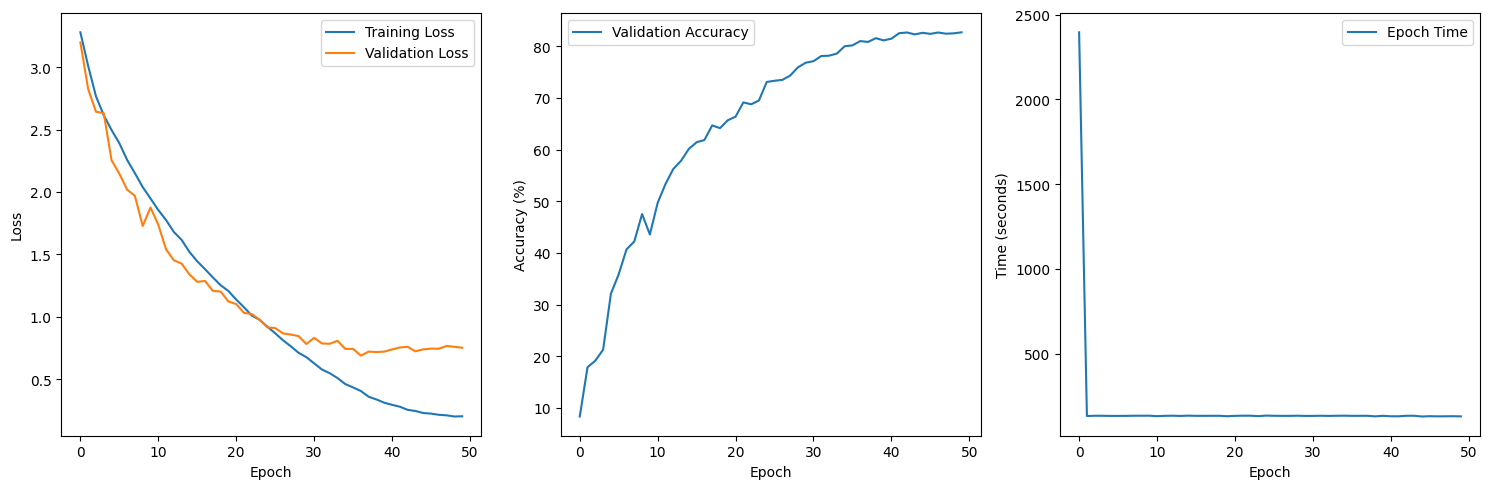

Best Validation Accuracy: 82.73%


In [9]:
if __name__ == '__main__':
    model, history, best_acc = train_vgg16()

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(history['epoch_times'], label='Epoch Time')
    plt.xlabel('Epoch')
    plt.ylabel('Time (seconds)')
    plt.legend()

    plt.tight_layout()
    plt.show()

    print(f'Best Validation Accuracy: {best_acc:.2f}%')


Testing the best model...


<ipython-input-8-8ab622e8ea87>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)
<ipython-input-8-8ab622e8ea87>:27: FutureWarning: `torch.


Test Accuracy: 81.48%

Classification Report:
               precision    recall  f1-score   support

     aloevera       0.90      0.88      0.89       200
       banana       0.88      0.69      0.77       200
      bilimbi       0.89      0.91      0.90       200
   cantaloupe       0.46      0.83      0.59       200
      cassava       0.67      0.81      0.73       200
      coconut       0.77      0.58      0.66       200
         corn       0.83      0.91      0.86       200
     cucumber       0.91      0.93      0.92       200
      curcuma       0.76      0.89      0.82       200
     eggplant       0.85      0.94      0.90       200
     galangal       0.78      0.95      0.86       200
       ginger       0.70      0.75      0.72       200
        guava       0.90      0.85      0.87       200
         kale       0.90      0.84      0.87       200
    longbeans       0.87      0.94      0.91       200
        mango       0.73      0.64      0.68       200
        melon    

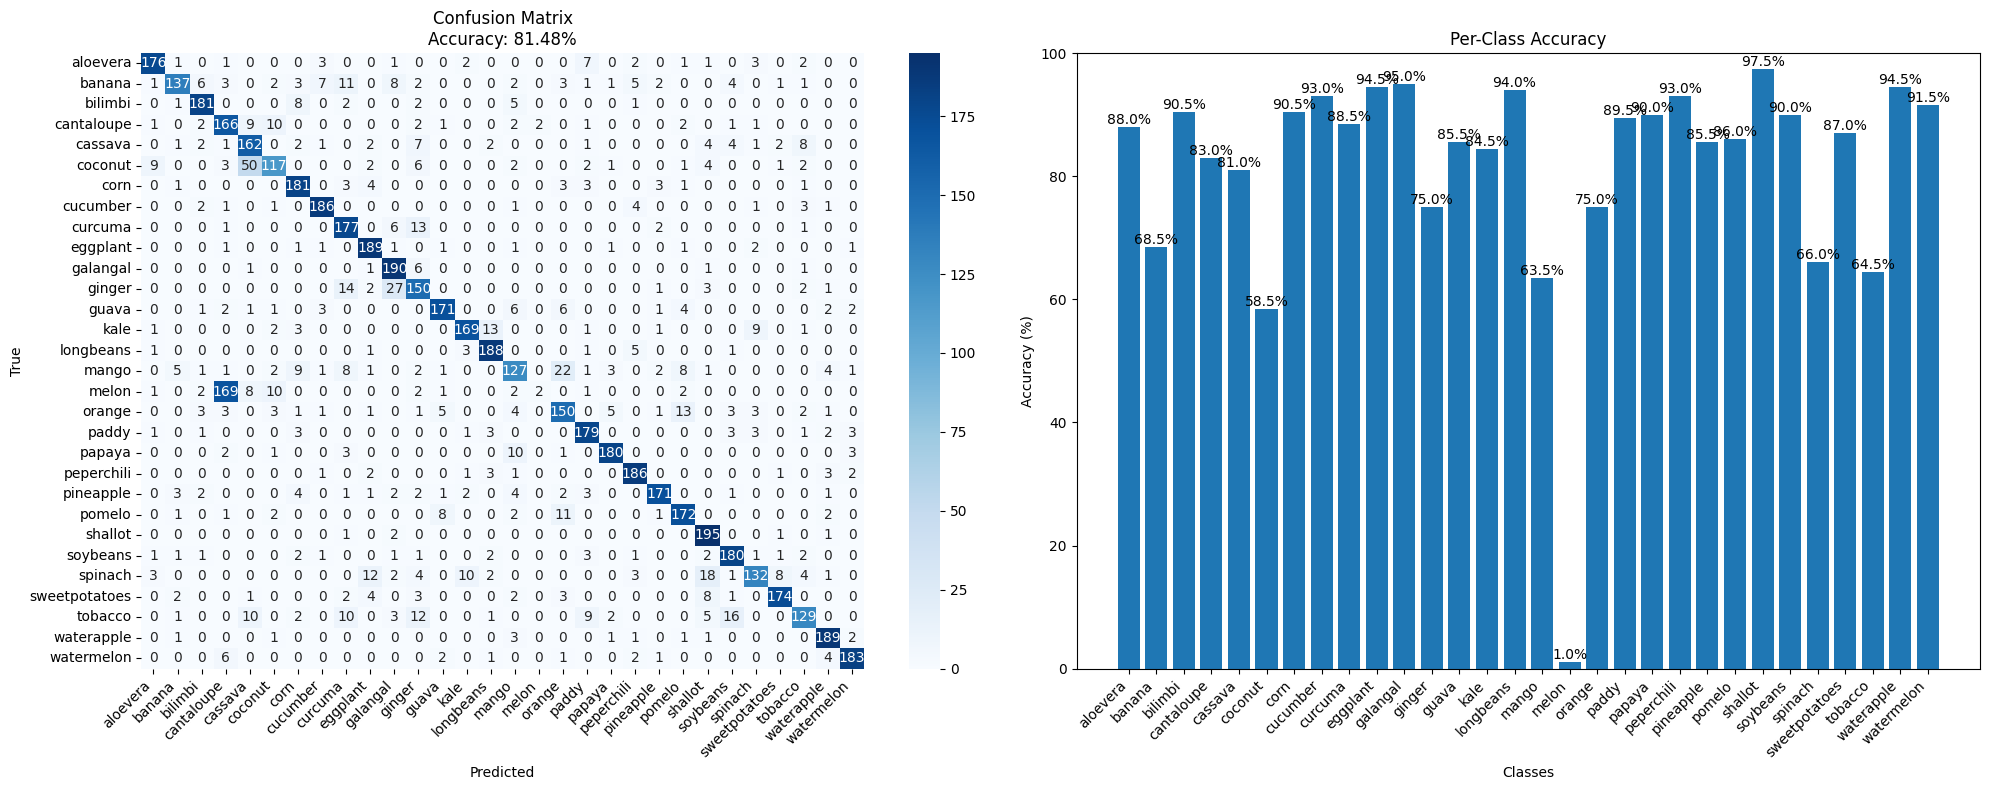

In [10]:
print("\nTesting the best model...")
model_path = '/content/drive/MyDrive/Colab Notebooks/Capstone Project/best_vgg16.pth'
accuracy, confusion_mat, report = test_model(model_path, test_loc, VGG16)